In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import os

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-13 20:20:30.386330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 20:20:30.386472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 20:20:30.537611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Minh: Data Augmentation cho các lớp có data nhỏ + khảo sát dataset
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [3]:
data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
print(len(data[' pixels'].iloc[0].split()))

2304


In [5]:
# def total_image(data):
#     return len(data)

# def usage_count(data):
#     return data[' Usage'].value_counts()

# def plot_class_count(data):
#     emotion_counts = data[data['emotion']].value_counts()
#     emotion_counts.plot(kind='bar', color='skyblue')
#     plt.xlabel('Emotion')
#     plt.ylabel('Count')
#     plt.title('Emotion Counts')
#     plt.show()

# print("Total image:", total_image(data))
# print(usage_count(data))
# plot_class_count(data)

In [6]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [7]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [8]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [9]:
def plot_class_count(train_image_label, name):
    # Calculate the counts of each label in the training set
    emotion_counts = np.unique(train_image_label, return_counts=True)
    
    # Plot the counts
    plt.bar(emotion_counts[0], emotion_counts[1], color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title(f'Emotion Counts in {name} Set')
    plt.show()

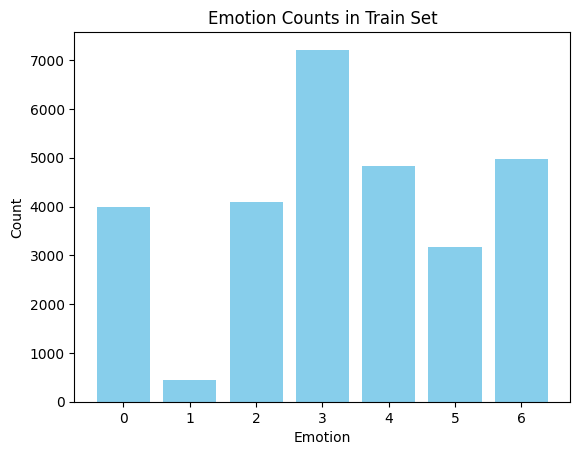

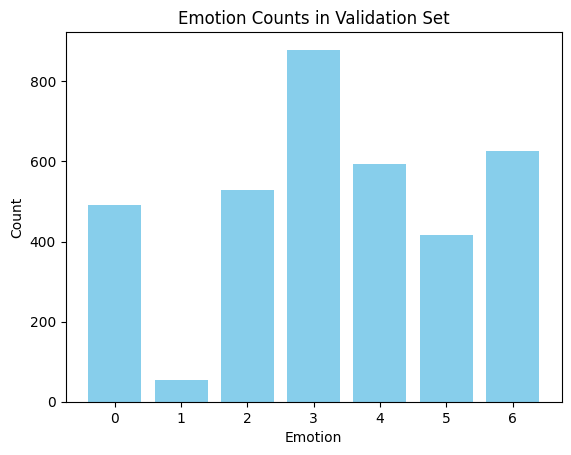

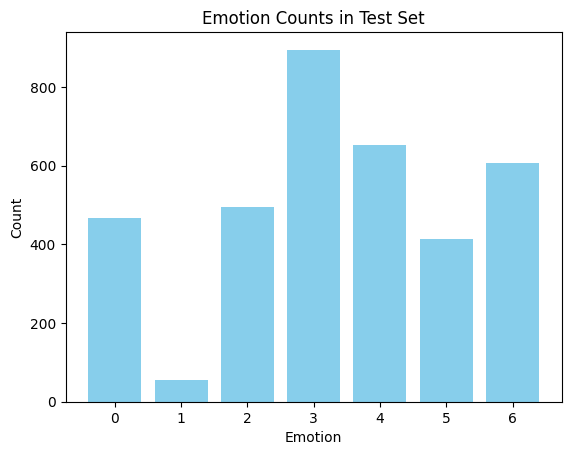

In [10]:
plot_class_count(train_image_label, "Train")
plot_class_count(val_image_label, "Validation")
plot_class_count(test_image_label, "Test")
#data augmention chi lam tren train, test va val de nguyen

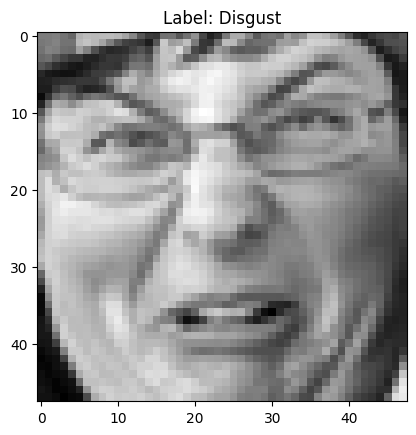

In [11]:
#Accessing the images with label: 
label = 1  
images_with_label = train_images[np.where(train_image_label == label)[0]]

# Accessing the first image with that label
first_image = images_with_label[0]

plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {emotions[label]}")
plt.show()

In [12]:
batch_size = 32

def augment(image, seed):
    # Make a new seed for each augmentation operation
    seed = tf.convert_to_tensor(seed, dtype=tf.int32)

    # Apply various augmentations
    new_seed = tf.random.experimental.stateless_split(seed, num=8)

    # Random brightness adjustment
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed[0])
    
    # Random contrast adjustment
    image = tf.image.stateless_random_contrast(image, lower=0.5, upper=1.5, seed=new_seed[1])
    
    # Random crop (keeping the size same here for simplicity)
    image = tf.image.stateless_random_crop(image, size=[48, 48, 1], seed=new_seed[2])
    
    # Random horizontal flip
    image = tf.image.stateless_random_flip_left_right(image, seed=new_seed[3])
    
    # Random vertical flip
    image = tf.image.stateless_random_flip_up_down(image, seed=new_seed[4])
    
    # Random JPEG quality adjustment
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=new_seed[6])

    # Ensure pixel values are within the [0, 1] range
    image = tf.clip_by_value(image, 0, 1)

    return image

# Increase the dataset size by generating N augmented versions of each image
N = 5 

# Create a random seed
augmented_images = []
for img in images_with_label:
    for _ in range(N):
        seed = np.random.randint(0, 10000, size=(2,))  # Create a new seed for each augmentation
        augmented_image = augment(img, seed)
        augmented_images.append(augmented_image.numpy())  # Convert Tensor back to NumPy array

# Convert the list of augmented images back to a NumPy array
augmented_images = np.array(augmented_images)

# Print the number of images before and after augmentation
print(f"Original number of images: {len(images_with_label)}")
print(f"Number of images after augmentation: {len(augmented_images)}")


Original number of images: 436
Number of images after augmentation: 2180


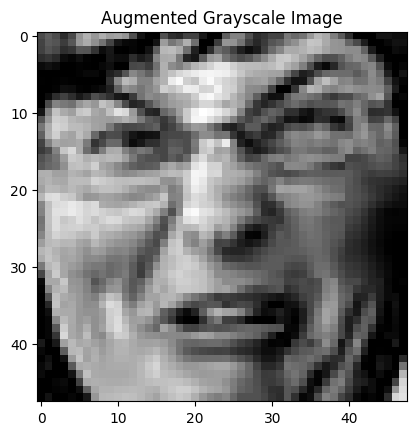

In [13]:
# Displaying the first augmented image
plt.imshow(augmented_images[0].squeeze(), cmap='gray')
plt.title(f"Augmented Grayscale Image")
plt.show()

In [14]:
# Đoàn Anh: Tạo mô hình và huấn luyện mô hình

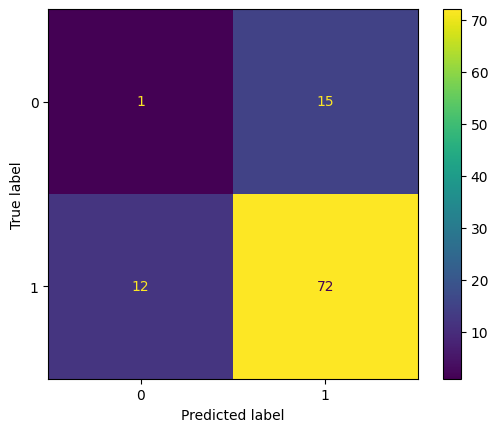

In [15]:
# Hùng: Đánh giá mô hình và test mô hình.
actual = np.random.binomial(1,.9,size = 100)
predicted = np.random.binomial(1,.9,size = 100)

confusion_matrix = confusion_matrix(actual, predicted)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()